# Coin Toss with ADVI Ajax

In [33]:
try:
  from ajax import Prior, Likelihood, Variational, ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import Prior, Likelihood, Variational, ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
tfd = tfp.distributions
tfb = tfp.bijectors

In [34]:
with open("../data/coin_toss/coin_toss",'rb') as f:
    data = pickle.load(f)
data

{'data': array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int32),
 'prior': {'alpha': 10, 'beta': 15}}

In [35]:
dataset = data['data']
alpha_param = data['prior'] ['alpha']
beta_param = data['prior']['beta']

In [36]:
prior = Prior(
    distributions = {
        "theta" : tfd.Beta(alpha_param, beta_param)
        }
    )

In [37]:
def link_function(samples):
  probs = samples["theta"]
  return {"probs" : probs}

In [38]:
likelihood = Likelihood(tfd.Bernoulli, link_function)

In [39]:
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Sigmoid()},
    vi_type="full_rank"
)

In [40]:
advi = ADVI(prior, likelihood, variational, dataset)

In [41]:
params = variational.get_params()

In [44]:
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss),static_argnames=['n_samples'])

In [45]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed,n_samples = 1)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [46]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(10)}#key value matters keep it 10 :(
carry,loss = jax.lax.scan(update_func, carry,xs = None,length= 500) 

## Noisy Loss

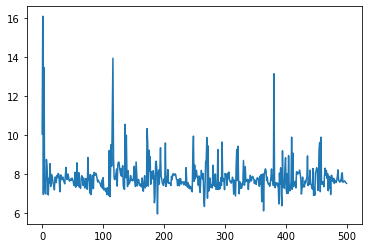

In [47]:
plt.plot(loss)

In [48]:
keys = jax.random.PRNGKey(1)
variational.set_params(carry['params'])


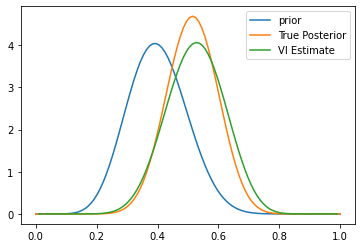

In [49]:
beta_dist_one = tfd.Beta(alpha_param, beta_param)
x = jnp.linspace(0,1,100)
plt.plot(x,beta_dist_one.prob(x),label="prior")
one= jnp.sum(dataset==1).astype('float32')
zero= jnp.sum(dataset==0).astype('float32')
beta_dist = tfd.Beta(alpha_param+one, beta_param+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")
di = {"theta":x}
plt.plot(x,jnp.exp(variational.log_prob(di)),label = "VI Estimate")
plt.legend()

In [50]:
with open("../results/coin_toss/results_data/coin_toss_VI_Ajax_result",'wb') as f:
    pickle.dump(variational, f,protocol = 1)